In [1]:
# Import basic packages 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 10 # Ensure reproducible results
%matplotlib inline

In [2]:
#import all data
data = pd.read_csv(r'd:\msc-project\data\final\features_with_outcome.csv',encoding='utf=8')

In [3]:
len(data)

28727

In [4]:
data.head(3)

,org_uuid,people_num_founder,people_is_founder_gender_diversity,people_num_bachelor,people_num_master,people_num_phd,people_num_mba,people_num_stem,people_num_ivy_league,people_num_top_100,...,network_has_facebook_url,network_has_linkedin_url,network_has_twitter_url,network_has_homepage,network_is_attend_top_event,network_has_description,investor_is_cbtop1000,investor_is_no_rank,investor_is_not_cbtop1000,outcome
0,9dc17185-743d-5fbc-f03b-ad0c81c8795d,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,1
1,9c8adac6-5c8e-9344-b763-6beab966c63c,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,1,0,1
2,6749cc07-efed-ff09-4efe-43faf6f580de,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,1,1


In [5]:
data['outcome'].value_counts()

0    22066
1     6661
Name: outcome, dtype: int64

In [6]:
y_data = data['outcome']
X_data = data.drop(columns = ['org_uuid','outcome'])

In [7]:
#splitting data into test and full training set
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X_data,y_data, 
                                                              test_size = 0.2,
                                                              stratify=y_data)

In [8]:
y_train_full.value_counts()

0    17652
1     5329
Name: outcome, dtype: int64

In [9]:
#splitting full training data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, 
                                                  test_size = 0.2,
                                                  stratify=y_train_full)

In [10]:
#define score function

def compute_score (y_act,y_pred,y_pred_proba):
    
    from sklearn.metrics import accuracy_score,log_loss,recall_score,precision_score,f1_score
    
    accuracy = accuracy_score (y_act,y_pred)
    log_loss = log_loss (y_act,y_pred_proba)
    recall = recall_score (y_act,y_pred)
    precision = precision_score (y_act,y_pred)
    f1 = f1_score (y_act,y_pred)
    
    return accuracy,log_loss,recall,precision,f1

In [11]:
from imblearn.over_sampling import RandomOverSampler

ModuleNotFoundError: No module named 'imblearn'

In [20]:
#run classifier

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
random_state = 42

names = ["Dummy, most frequent", #dummy classifer
         "Gaussian Naive Bayes", #"Logistic Regression", #white-box method
         "Random Forest", "Xgboost", #white-box
         "Linear SVM", "RBF SVM", #black-box
         "MLP", "MLP stronger reg", #black-box
         ]

classifiers = [
    DummyClassifier(strategy='most_frequent'),
    GaussianNB(),
    #LogisticRegression(max_iter=1000),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    XGBClassifier(),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=800),  # default regularisation
    MLPClassifier(random_state=random_state, max_iter=800, alpha=1),  # more regularisation
    ]

# Training score
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy
re_train_score = {}  # recall
pr_train_score = {}  # precision
f1_train_score = {}  # f1 score

# Validation
ca_val_score = {} 
ce_val_score = {}
re_val_score = {}
pr_val_score = {}
f1_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    
    y_train_predict = clf.predict(X_train)
    y_train_predict_proba = clf.predict_proba(X_train)
    acc, log_loss, re, pr, f1 = compute_score (y_train,y_train_predict,y_train_predict_proba)
    
    ca_train_score[name] = acc
    ce_train_score[name] = log_loss
    re_train_score[name] = re
    pr_train_score[name] = pr
    f1_train_score[name] = f1
    
    y_val_predict = clf.predict(X_val)
    y_val_predict_proba = clf.predict_proba(X_val)
    acc, log_loss, re, pr, f1 = compute_score (y_val,y_val_predict,y_val_predict_proba)
    ca_val_score[name] = acc
    ce_val_score[name] = log_loss
    re_val_score[name] = re
    pr_val_score[name] = pr
    f1_val_score[name] = f1

#Print Result
print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Recall\u2191',
    'Accuracy\u2191', 'Recall\u2191'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_recall=re_val_score[clf],
        train_accuracy=ca_train_score[clf], train_recall=re_train_score[clf]))

C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[14:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification performance on validation set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑      Recall↑    Accuracy↑      Recall↑
------------------------------------------------------------------------


KeyError: 'val_logloss'

In [26]:
#Print Result
print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'log loss\u2193',
    'Accuracy\u2191', 'log loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_log_loss:>13.3f}{train_accuracy:>13.3f}{train_log_loss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_log_loss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_log_loss=ce_train_score[clf]))

Classification performance on validation set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑    log loss↓    Accuracy↑    log loss↓
------------------------------------------------------------------------
Dummy, most frequent        0.768        8.009        0.768        8.009
Gaussian Naive Bayes        0.730        2.898        0.722        2.930
Random Forest               0.782        0.474        0.822        0.429
Xgboost                     0.781        0.482        0.866        0.342
Linear SVM                  0.772        0.489        0.771        0.490
RBF SVM                     0.771        0.524        0.770        0.526
MLP                         0.750        0.647        0.867        0.308
MLP stronger reg            0.781        0.477        0.783        0.477


In [23]:
#Print Result
print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Precision\u2191', 'Recall\u2191',
    'Precision\u2191', 'Recall\u2191'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_precision:>13.3f}{val_recall:>13.3f}{train_precision:>13.3f}{train_recall:>13.3f}".format(
        method=clf, val_precision=pr_val_score[clf], val_recall=re_val_score[clf],
        train_precision=pr_train_score[clf], train_recall=re_train_score[clf]))

Classification performance on validation set: 

                       -------Validation--------   ------Training-------
Method                 Precision↑      Recall↑   Precision↑      Recall↑
------------------------------------------------------------------------
Dummy, most frequent        0.000        0.000        0.000        0.000
Gaussian Naive Bayes        0.428        0.484        0.412        0.470
Random Forest               0.626        0.149        0.948        0.247
Xgboost                     0.556        0.285        0.904        0.474
Linear SVM                  0.815        0.021        0.734        0.016
RBF SVM                     0.750        0.017        0.643        0.015
MLP                         0.438        0.277        0.828        0.540
MLP stronger reg            0.625        0.136        0.656        0.131


In [27]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


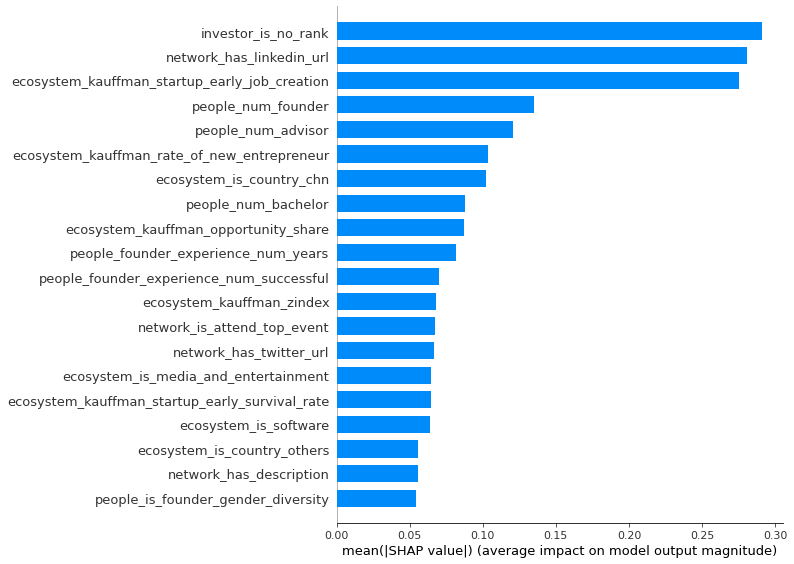

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")